In [5]:
from pybaseball import statcast
import pandas as pd

# Step 1: Load 2025 Statcast data
df = statcast(start_dt="2025-03-28", end_dt="2025-10-01")

# Step 2: Filter relevant columns
df_filtered = df[['events', 'description', 'delta_pitcher_run_exp', 'balls', 'strikes']]

# Step 3: Remove irrelevant or misleading outcomes
df_filtered = df_filtered[~df_filtered['description'].isin(['pitchout', 'catcher_interf', 'field_error'])]

# Step 4: Standardize certain descriptions
df_filtered['description'] = df_filtered['description'].replace({
    'blocked_ball': 'ball',
    'swinging_strike_blocked': 'swinging_strike',
    'missed_bunt': 'swinging_strike',
    'foul_tip': 'swinging_strike',
    'bunt_foul_tip': 'swinging_strike',
    'foul_bunt': 'swinging_strike'
})

# Step 5: Replace 'hit_into_play' with actual event result
mask = df_filtered['description'] == 'hit_into_play'
df_filtered.loc[mask, 'description'] = df_filtered.loc[mask, 'events']

# Step 6: Collapse out events into 'field_out'
out_events = [
    'double_play', 'triple_play', 'force_out', 'fielders_choice',
    'fielders_choice_out', 'grounded_into_double_play',
    'sac_bunt', 'sac_fly', 'sac_fly_double_play'
]
df_filtered['description'] = df_filtered['description'].replace(
    {evt: 'field_out' for evt in out_events}
)


# Step 8: Summary table for final PA outcomes
pa_outcomes = ['swinging_strike', 'called_strike' 'ball', 'hit_by_pitch', 'field_out', 'single', 'double', 'triple', 'home_run', 'foul']
pa_summary = df_filtered[df_filtered['description'].isin(pa_outcomes)].groupby('description')['delta_pitcher_run_exp'].agg(
    average_delta_run_exp='mean',
    sample_size='count'
).sort_values(by='average_delta_run_exp', ascending=False).reset_index()

# Display the results
print("PA-level outcome run values:")
print(pa_summary)

save_path = "C:/Users/franc/Jupyter/MLB2/run_values.csv"
df_filtered.to_csv(save_path, index=False)

# Calculate absolute delta run exp
df_filtered['abs_delta'] = df_filtered['delta_pitcher_run_exp'].abs()

# Group by count and compute average leverage
count_leverage = df_filtered.groupby(['balls', 'strikes'])['abs_delta'].agg(
    leverage='mean',
    sample_size='count'
).reset_index().sort_values(by='leverage', ascending=False)

# View or export
print(count_leverage)


This is a large query, it may take a moment to complete


100%|██████████| 188/188 [01:24<00:00,  2.23it/s]
C:\Users\franc\anaconda3\Lib\site-packages\pybaseball\statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


PA-level outcome run values:
       description  average_delta_run_exp  sample_size
0        field_out               0.246968        52686
1  swinging_strike               0.112392        53474
2             foul               0.033845        79046
3     hit_by_pitch              -0.365036         1192
4           single              -0.448714        16462
5           double               -0.72834         4867
6           triple              -0.996116          396
7         home_run              -1.509141         3411
    balls  strikes  leverage  sample_size
11      3        2  0.252468        22201
10      3        1  0.199664         9301
8       2        2  0.164147        36764
7       2        1  0.159239        22881
6       2        0  0.140292        14411
5       1        2   0.12344        43235
4       1        1  0.122475        44542
3       1        0   0.11233        43053
9       3        0  0.106182         4382
2       0        2  0.099524        29612
1       0     

In [1]:
import pandas as pd

# Load the full Statcast dataset (2021–2024)
file_path = "C:/Users/franc/Jupyter/statcast_2021_2024.csv"

# Load into DataFrame
df = pd.read_csv(file_path)

# Print shape and columns
print(f"Dataset loaded with shape: {df.shape}")
print("\nColumns:\n", df.columns.tolist())


# Define all modeling variables (continuous + discrete)
model_vars = [
    'release_speed',
    'release_spin_rate',
    'pfx_x', 'pfx_z',
    'plate_x', 'plate_z',
    'release_extension',
    'stand', 'p_throws',
    'balls', 'strikes',
    'pitch_number'
]

# Drop rows with any NA in these core variables
filtered_df = df.dropna(subset=model_vars)

# Remove invalid count states: balls > 3 or strikes > 2
filtered_df = filtered_df[
    (filtered_df['balls'] <= 3) &
    (filtered_df['strikes'] <= 2)
]

# Optional: re-confirm NA status in each variable
na_summary = filtered_df[model_vars].isna().sum().reset_index()
na_summary.columns = ['Variable', 'Missing_Count']
na_summary['Missing_Percent'] = (na_summary['Missing_Count'] / len(filtered_df)) * 100

# Show NA report (should all be 0 now)
print(f"Remaining rows after full cleaning: {len(filtered_df):,}\n")
print(na_summary.sort_values(by='Missing_Count', ascending=False))

# List of discrete vars (plus target)
discrete_vars = ['stand', 'p_throws', 'balls', 'strikes', 'description', 'events', 'pitch_number']

# Print unique values for each
for col in discrete_vars:
    print(f"Unique values in '{col}':")
    print(sorted(filtered_df[col].dropna().unique()))
    print()

Dataset loaded with shape: (2854047, 119)

Columns:
 ['pitch_type', 'game_date', 'release_speed', 'release_pos_x', 'release_pos_z', 'player_name', 'batter', 'pitcher', 'events', 'description', 'spin_dir', 'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des', 'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type', 'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'umpire', 'sv_id', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed', 'release_spin_rate', 'release_extension', 'game_pk', 'fielder_2', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle', 'woba_value', 'wob

In [2]:
# === STEP 1: Drop meaningless or misleading outcomes ===

# Drop pitchouts entirely — not representative of pitch intent
filtered_df = filtered_df[filtered_df['description'] != 'pitchout']

# Drop catcher interference — does not reflect pitcher skill
filtered_df = filtered_df[filtered_df['events'] != 'catcher_interf']
filtered_df = filtered_df[filtered_df['description'] != 'foul_pitchout']

# === STEP 2: Recode rare/uninformative pitch descriptions ===

# Collapse redundant/ambiguous outcomes into core pitch classes
filtered_df['description'] = filtered_df['description'].replace({
    'blocked_ball': 'ball',
    'swinging_strike_blocked': 'swinging_strike',
    'missed_bunt': 'swinging_strike',
    'foul_tip': 'swinging_strike',
    'bunt_foul_tip': 'swinging_strike',
    'foul_bunt': 'swinging_strike'
})

# === STEP 3: Replace 'hit_into_play' with actual event outcome ===
mask = filtered_df['description'] == 'hit_into_play'
filtered_df.loc[mask, 'description'] = filtered_df.loc[mask, 'events']

# Collapse BIP outs (including errors and sacrifices) into one label
out_events = [
    'double_play', 'triple_play', 'force_out', 'fielders_choice',
    'fielders_choice_out', 'grounded_into_double_play',
    'sac_bunt', 'sac_fly', 'sac_fly_double_play',
    'field_error', 'sac_bunt_double_play'
]

filtered_df['description'] = filtered_df['description'].replace(
    {evt: 'field_out' for evt in out_events}
)

# === NEW: Collapse called and swinging strikes to unified 'strike' label ===
filtered_df['description'] = filtered_df['description'].replace({
    'called_strike': 'strike',
    'swinging_strike': 'strike'
})

# === NEW: Everything else becomes 'non_strike' ===
filtered_df['description'] = filtered_df['description'].apply(
    lambda x: 'strike' if x == 'strike' else 'non_strike'
)

# === STEP 6: Drop any rows with missing descriptions (very rare)
filtered_df = filtered_df[filtered_df['description'].notna()]

# === Final Check ===
print(f"Remaining rows after cleaning and mapping descriptions: {len(filtered_df):,}")
print(f"Unique values in 'description': {sorted(filtered_df['description'].unique())}")

# === Step: Encode categorical variables and finalize df_encoded ===
df_encoded = filtered_df.copy()

# One-hot encode stand and p_throws
df_encoded['stand_R'] = (df_encoded['stand'] == 'R').astype(int)
df_encoded['p_throws_R'] = (df_encoded['p_throws'] == 'R').astype(int)
df_encoded['pitch_number_capped'] = df_encoded['pitch_number'].clip(upper=8)

# Drop any remaining rows with NA in modeling variables
input_cols = [
    'release_speed', 'release_spin_rate',
    'pfx_x', 'pfx_z', 'plate_x', 'plate_z',
    'release_extension', 'balls', 'strikes',
    'stand_R', 'p_throws_R', 'pitch_number_capped'
]
df_encoded = df_encoded.dropna(subset=input_cols + ['description'])

# === REPLACEMENT: Define binary target directly instead of label encoding ===
df_encoded['is_strike'] = (df_encoded['description'] == 'strike').astype(int)

# === OPTIONAL DEBUG PRINT ===
print("Target breakdown:\n", df_encoded['is_strike'].value_counts())

model_vars = [
    'release_speed', 'release_spin_rate', 'pfx_x', 'pfx_z',
    'plate_x', 'plate_z', 'release_extension',
    'balls', 'strikes', 'stand_R', 'p_throws_R', 'pitch_number', 'is_strike'
]

print(df_encoded[model_vars].dtypes)

# Create a unique PA_ID for each plate appearance
df_encoded['PA_ID'] = (
    df_encoded['game_date'].astype(str) + "_" +
    df_encoded['inning'].astype(str) + "_" +
    df_encoded['inning_topbot'].astype(str) + "_" +
    df_encoded['batter'].astype(str) + "_" +
    df_encoded['pitcher'].astype(str) + "_" +
    df_encoded['at_bat_number'].astype(str)
)


Remaining rows after cleaning and mapping descriptions: 2,825,843
Unique values in 'description': ['non_strike', 'strike']
Target breakdown:
 is_strike
0    2011128
1     814715
Name: count, dtype: int64
release_speed        float64
release_spin_rate    float64
pfx_x                float64
pfx_z                float64
plate_x              float64
plate_z              float64
release_extension    float64
balls                  int64
strikes                int64
stand_R                int32
p_throws_R             int32
pitch_number           int64
is_strike              int32
dtype: object


In [4]:
pitch_percentages = (
    df_encoded['pitch_number']
    .value_counts(normalize=True)
    .sort_index() * 100
)

# Round and print
print(pitch_percentages.round(5))
print(df_encoded['PA_ID'].head())
# Step 1: Count pitches per plate appearance
pa_lengths = df_encoded.groupby('PA_ID').size()

# Step 2: Compute normalized percentage distribution
pa_length_percentages = pa_lengths.value_counts(normalize=True).sort_index() * 100

# Step 3: Round and display
print(pa_length_percentages.round(5))


pitch_number
1     25.63168
2     22.75417
3     18.91977
4     14.35674
5      9.56670
6      5.25125
7      2.18115
8      0.84470
9      0.31495
10     0.11593
11     0.04027
12     0.01504
13     0.00488
14     0.00191
15     0.00057
16     0.00028
Name: proportion, dtype: float64
0    2021-10-01_9_Bot_596059_552640_75
1    2021-10-01_9_Bot_596059_552640_75
2    2021-10-01_9_Bot_596059_552640_75
3    2021-10-01_9_Bot_596059_552640_75
4    2021-10-01_9_Bot_596142_552640_74
Name: PA_ID, dtype: object
1     11.41204
2     15.02260
3     17.84593
4     18.69107
5     16.76722
6     11.85978
7      5.15022
8      2.03940
9      0.76729
10     0.29066
11     0.09601
12     0.03948
13     0.01142
14     0.00468
15     0.00110
16     0.00110
Name: proportion, dtype: float64


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# === Temporal Convolutional Block ===
class TemporalBlock(nn.Module): #a residual block with 1D causal convolutions (building block of Temporal Convolutional Netowrk). This defines a reusable block. Each block learns temporal patterns using two convolutional layers and a residual connection (like ResNet).
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, dropout): 
        # in_channels=# of input features. out_channels=# of filters/output channels (32). kernel_size=size of convolution window. 
        # stride=how far to slide kernel (always 1, move one step at a time). 
        # dilation=spacing between kernel elements (doubles with depth). 
        # dropout=regularization, randomly zero out some weights during training.

        super().__init__()
        padding = (kernel_size - 1) * dilation // 2  # ensures output length stays the same as input

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               stride=stride, padding='same', dilation=dilation)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        # applies a causal 1D convolution, followed by ReLU activation and then a dropout which prevents overfitting

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               stride=stride, padding='same', dilation=dilation)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        # applies a second convolution to the result of the first. Stacking two convolutions like this lets the block learn more complex features

        # Match dimensions if in_channels != out_channels
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        # uses 1x1 convolution to match shapes, allows us to add input to the output later

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        res = x if self.downsample is None else self.downsample(x)
        return F.relu(out + res)
        # forward pass. applies both layers, adds original input back in and helps training by allowing gradient flow through shortcut paths

# === Full TCN Model ===
class TCN(nn.Module): #full TCN pipeline
    def __init__(self, input_size, output_size, num_channels, kernel_size=2, dropout=0.2): 
        # input size=#features per pitch (12), output_size=# classes to predict (9).
        # num_channels=list defining number of filters in each block (32).
        # kernel_size=size of temporal window. Dropout=amount dropout applied

        super().__init__()
        layers = []
        num_levels = len(num_channels) #loop over 2 TCN layers
        for i in range(num_levels):
            dilation_size = 2 ** i #double dilation to expand receptive field
            in_channels = input_size if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers.append(
                TemporalBlock( #add each temporal block to the model
                    in_channels, out_channels, kernel_size,
                    stride=1,
                    dilation=dilation_size,
                    dropout=dropout
                )
            )
        self.network = nn.Sequential(*layers)
        # builds the network 

        self.linear = nn.Linear(num_channels[-1], output_size) 
        # after passing through all TCN blocks, apply linear layer at each time step and convert final representation into class logits of size 9

    def forward(self, x):
        # Input: [batch, seq_len, input_size]
        # TCN expects: [batch, input_size, seq_len]
        x = x.transpose(1, 2)  # [Batch, Features, sequence_length] for Conv1D
        out = self.network(x)
        out = out.transpose(1, 2)  # [Batch, seq_len, Channels]
        logits = self.linear(out)  # [Batch, seq_len, output_size]
        return logits


model = TCN(
    input_size=12,          # number of features per pitch
    output_size=2,          # number of classes: 8 terminal + 1 continue
    num_channels=[32, 32],  # depth and width of the network
    kernel_size=2,
    dropout=0.1
)


In [6]:
import numpy as np
import torch

# Set your sequence length
SEQ_LENGTH = 6

# Extract relevant columns
input_cols = ['release_speed', 'release_spin_rate',
    'pfx_x', 'pfx_z', 'plate_x', 'plate_z',
    'release_extension', 'balls', 'strikes',
    'stand_R', 'p_throws_R', 'pitch_number_capped']

target_col = 'is_strike'

# Group by PA_ID
grouped = df_encoded.sort_values("PA_ID").groupby("PA_ID", sort=False)

X_list = []
y_list = []

for idx, (_, group) in enumerate(grouped):
    # Sort by pitch_number just in case
    group = group.sort_values('pitch_number')

    # Extract inputs and target
    X_seq = group[input_cols].astype('float32').values
    y_seq = group[target_col].values.astype('int64')

    # Truncate if too long
    if len(X_seq) > SEQ_LENGTH:
        X_seq = X_seq[:SEQ_LENGTH]
        y_seq = y_seq[:SEQ_LENGTH]

    # Pad if too short
    if len(X_seq) < SEQ_LENGTH:
        pad_len = SEQ_LENGTH - len(X_seq)
        X_pad = np.zeros((pad_len, len(input_cols)), dtype='float32')
        y_pad = np.full(pad_len, -100, dtype='int64')  # Use -100 to ignore padded targets

        X_seq = np.vstack([X_seq, X_pad])
        y_seq = np.concatenate([y_seq, y_pad])

    X_list.append(X_seq)
    y_list.append(y_seq)

    if idx % 50000 == 0:
        print(f"Processed {idx} PAs...")

# Convert to tensors
X_tensor = torch.tensor(np.stack(X_list), dtype=torch.float32)
y_tensor = torch.tensor(np.stack(y_list), dtype=torch.long)

print("X shape:", X_tensor.shape)  # [batch, seq_len, input_size]
print("y shape:", y_tensor.shape)  # [batch, seq_len]

from torch.utils.data import TensorDataset, DataLoader, random_split
import torch
import numpy as np
import random

# === Set seed globally ===
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Step 1: Wrap tensors in a dataset
full_dataset = TensorDataset(X_tensor, y_tensor)

# Step 2: Train/validation split with deterministic generator
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
generator = torch.Generator().manual_seed(SEED)
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=generator)

# Step 3: Create seeded DataLoaders (for reproducibility with num_workers > 0)
def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

BATCH_SIZE = 128

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,  # increase if needed
    worker_init_fn=seed_worker,
    generator=torch.Generator().manual_seed(SEED)
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    worker_init_fn=seed_worker,
    generator=torch.Generator().manual_seed(SEED)
)

print(f"Training samples: {len(train_dataset):,}")
print(f"Validation samples: {len(val_dataset):,}")


Processed 0 PAs...
Processed 50000 PAs...
Processed 100000 PAs...
Processed 150000 PAs...
Processed 200000 PAs...
Processed 250000 PAs...
Processed 300000 PAs...
Processed 350000 PAs...
Processed 400000 PAs...
Processed 450000 PAs...
Processed 500000 PAs...
Processed 550000 PAs...
Processed 600000 PAs...
Processed 650000 PAs...
Processed 700000 PAs...
X shape: torch.Size([726978, 6, 12])
y shape: torch.Size([726978, 6])
Training samples: 581,582
Validation samples: 145,396


In [6]:
print("Logits shape:", outputs[valid].shape)




NameError: name 'outputs' is not defined

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
import numpy as np

# === Set random seed for reproducibility ===
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# === Training config ===
BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 0.001

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Move model to device
model.to(device)

# Optional class weights (adjust if strike class is underrepresented)
weights = torch.tensor([1.0, 0.8], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights, ignore_index=-100)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# === Training loop ===
for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0
    total_train_preds = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        outputs = outputs.view(-1, outputs.size(-1))  # [batch * seq_len, 2]
        y_batch = y_batch.view(-1)  # [batch * seq_len]

        valid = y_batch != -100
        loss = criterion(outputs[valid], y_batch[valid])
        total_train_loss += loss.item() * valid.sum().item()
        total_train_preds += valid.sum().item()

        loss.backward()
        optimizer.step()

    model.eval()
    total_val_loss = 0
    total_val_preds = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            outputs = model(X_batch)
            outputs = outputs.view(-1, outputs.size(-1))
            y_batch = y_batch.view(-1)

            valid = y_batch != -100
            loss = criterion(outputs[valid], y_batch[valid])
            total_val_loss += loss.item() * valid.sum().item()
            total_val_preds += valid.sum().item()

    avg_train_loss = total_train_loss / total_train_preds
    avg_val_loss = total_val_loss / total_val_preds

    print(f"Epoch {epoch+1}/{EPOCHS} | Avg Train Loss: {avg_train_loss:.4f} | Avg Val Loss: {avg_val_loss:.4f}")


Using device: cpu
Epoch 1/10 | Avg Train Loss: 0.2784 | Avg Val Loss: 0.2736
Epoch 2/10 | Avg Train Loss: 0.2789 | Avg Val Loss: 0.2707
Epoch 3/10 | Avg Train Loss: 0.2782 | Avg Val Loss: 0.2716
Epoch 4/10 | Avg Train Loss: 0.2783 | Avg Val Loss: 0.2810
Epoch 5/10 | Avg Train Loss: 0.2800 | Avg Val Loss: 0.2707
Epoch 6/10 | Avg Train Loss: 0.2784 | Avg Val Loss: 0.2744
Epoch 7/10 | Avg Train Loss: 0.2791 | Avg Val Loss: 0.2972
Epoch 8/10 | Avg Train Loss: 0.2777 | Avg Val Loss: 0.2699
Epoch 9/10 | Avg Train Loss: 0.2775 | Avg Val Loss: 0.2703
Epoch 10/10 | Avg Train Loss: 0.2773 | Avg Val Loss: 0.2734


In [40]:
torch.save(model.state_dict(), "C:/Users/franc/Jupyter/MLB2/final_strike_model.pth")


In [34]:
from sklearn.metrics import classification_report, brier_score_loss, log_loss
from sklearn.preprocessing import label_binarize

model.eval()
all_preds = []
all_targets = []
all_probs = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)  # [batch, seq_len, 2]
        probs = torch.softmax(outputs, dim=-1)  # [batch, seq_len, 2]
        preds = torch.argmax(probs, dim=-1)

        # Flatten
        y_batch = y_batch.view(-1)
        preds = preds.view(-1)
        probs = probs.view(-1, probs.size(-1))

        mask = (y_batch != -100)
        all_preds.extend(preds[mask].cpu().numpy())
        all_targets.extend(y_batch[mask].cpu().numpy())
        all_probs.extend(probs[mask].cpu().numpy())

# === Classification report ===
label_names = ['non_strike', 'strike']
print("\n=== Per-Class Validation Accuracy ===")
print(classification_report(all_targets, all_preds, target_names=label_names, digits=3))

# === Brier Scores ===
probs_array = np.array(all_probs)
true_y_bin = label_binarize(all_targets, classes=[0, 1])
if true_y_bin.shape[1] == 1:
    # Only one class present — duplicate column to allow indexing [:, 0] and [:, 1]
    true_y_bin = np.hstack([1 - true_y_bin, true_y_bin])

overall_brier = np.mean((probs_array - true_y_bin) ** 2)
print(f"\nMulticlass Brier Score: {overall_brier:.6f}")

print("\n=== Per-Class Brier Scores ===")
for i, class_name in enumerate(label_names):
    score = np.mean((probs_array[:, i] - true_y_bin[:, i]) ** 2)
    print(f"{class_name:15}: {score:.6f}")

# === Log Loss ===
log_loss_value = log_loss(all_targets, probs_array, labels=[0, 1])
print(f"\nMulticlass Log Loss: {log_loss_value:.6f}")


import pandas as pd

# Create DataFrame for predicted probabilities
probs_df = pd.DataFrame(probs_array, columns=['prob_non_strike', 'prob_strike'])

# Add predicted class column
preds_array = np.argmax(probs_array, axis=1)
preds_df = pd.DataFrame({'predicted_label': preds_array})

# Flatten validation features
val_X, _ = zip(*val_dataset)
val_X = torch.stack(val_X).numpy()
flat_features = val_X.reshape(-1, len(input_cols))
features_df = pd.DataFrame(flat_features, columns=input_cols)

# Match valid rows
features_df = features_df.iloc[:len(all_targets)].reset_index(drop=True)
labels_df = pd.DataFrame({'true_label': all_targets})

# Combine
final_df = pd.concat([features_df, labels_df, preds_df, probs_df], axis=1)

# Save
save_path = r"C:\Users\franc\Jupyter\MLB2\tcn_validation_predictions.csv"
final_df.to_csv(save_path, index=False)

print(f"Saved predictions to {save_path}")
print("Probability columns:", probs_df.columns.tolist())



=== Per-Class Validation Accuracy ===
              precision    recall  f1-score   support

  non_strike      0.923     0.866     0.894    386373
      strike      0.717     0.824     0.767    158948

    accuracy                          0.854    545321
   macro avg      0.820     0.845     0.831    545321
weighted avg      0.863     0.854     0.857    545321


Multiclass Brier Score: 0.095763

=== Per-Class Brier Scores ===
non_strike     : 0.095763
strike         : 0.095763

Multiclass Log Loss: 0.283910
Saved predictions to C:\Users\franc\Jupyter\MLB2\tcn_validation_predictions.csv
Probability columns: ['prob_non_strike', 'prob_strike']


In [35]:
import pandas as pd

# === Load validation prediction CSV ===
csv_path = "C:/Users/franc/Jupyter/MLB2/tcn_validation_predictions.csv"
df2 = pd.read_csv(csv_path)

# === Compute overall actual and expected strike percentages ===
overall_actual_strike_pct = df2['true_label'].mean()
overall_expected_strike_pct = df2['prob_strike'].mean()

print(f"📊 Overall Actual Strike%: {overall_actual_strike_pct:.4f}")
print(f"📊 Overall Expected Strike%: {overall_expected_strike_pct:.4f}")


📊 Overall Actual Strike%: 0.2915
📊 Overall Expected Strike%: 0.2929


In [36]:
# === Remove rows where all input features are zero (i.e., padding rows) ===

csv_path = "C:/Users/franc/Jupyter/MLB2/tcn_validation_predictions.csv"
df2 = pd.read_csv(csv_path)

input_cols = [
    'release_speed', 'release_spin_rate',
    'pfx_x', 'pfx_z',
    'plate_x', 'plate_z',
    'release_extension',
    'balls', 'strikes',
    'stand_R', 'p_throws_R',
    'pitch_number_capped'
]

mask_nonzero = df2[input_cols].ne(0).any(axis=1)
df2 = df2[mask_nonzero].reset_index(drop=True)

# === Save updated CSV ===
df2.to_csv(csv_path, index=False)
print(f"Padded rows removed. Cleaned CSV saved to: {csv_path}")

overall_actual_strike_pct = df2['true_label'].mean()
overall_expected_strike_pct = df2['prob_strike'].mean()

print(f"📊 Overall Actual Strike%: {overall_actual_strike_pct:.4f}")
print(f"📊 Overall Expected Strike%: {overall_expected_strike_pct:.4f}")


Padded rows removed. Cleaned CSV saved to: C:/Users/franc/Jupyter/MLB2/tcn_validation_predictions.csv
📊 Overall Actual Strike%: 0.2919
📊 Overall Expected Strike%: 0.2930


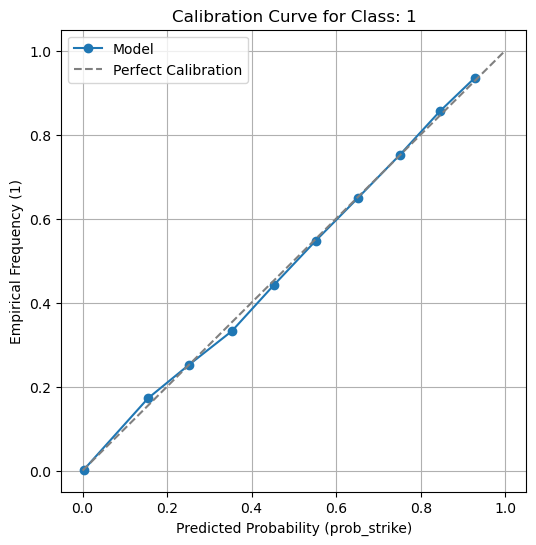

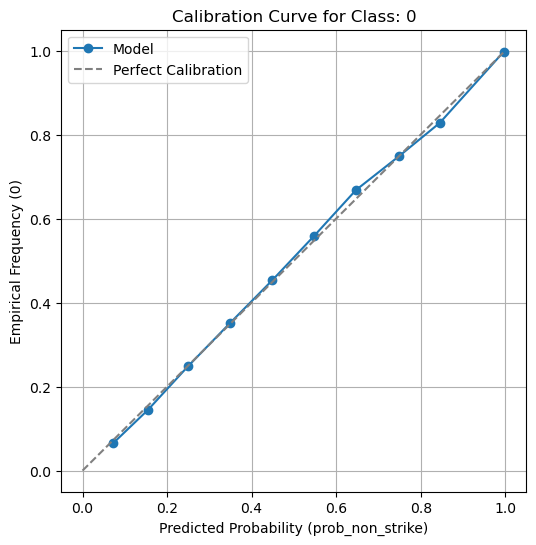

In [37]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

def plot_calibration(df, positive_class=1, prob_col='prob_strike'):
    y_true = (df['true_label'] == positive_class).astype(int)
    y_prob = df[prob_col].astype(float)

    # Sanity check
    if y_prob.nunique() <= 1:
        print(f"Probabilities in {prob_col} are constant.")
        return

    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)

    plt.figure(figsize=(6, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='Model')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.xlabel(f'Predicted Probability ({prob_col})')
    plt.ylabel(f'Empirical Frequency ({positive_class})')
    plt.title(f'Calibration Curve for Class: {positive_class}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Use 1 for strike, 0 for non-strike
plot_calibration(df2, positive_class=1, prob_col='prob_strike')
plot_calibration(df2, positive_class=0, prob_col='prob_non_strike')


In [65]:
print(df2[['true_label', 'prob_strike', 'prob_non_strike']].head(20))



    true_label   prob_strike  prob_non_strike
0            0  8.318579e-03         0.991681
1            0  1.464278e-07         1.000000
2            0  7.918818e-01         0.208118
3            1  5.644033e-01         0.435597
4            1  5.710445e-01         0.428956
5            0  2.393777e-03         0.997606
6            0  1.823077e-03         0.998177
7            0  5.595270e-01         0.440473
8            0  2.142371e-01         0.785763
9            0  9.263731e-05         0.999907
10           1  6.778260e-01         0.322174
11           0  1.933136e-02         0.980669
12           1  5.893037e-01         0.410696
13           0  2.614561e-01         0.738544
14           0  1.285647e-03         0.998714
15           1  7.318978e-01         0.268102
16           0  2.482954e-02         0.975170
17           0  7.528763e-01         0.247124
18           1  5.868716e-01         0.413128
19           1  6.881484e-01         0.311852


In [42]:
from pybaseball import statcast
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# === Rebuild model classes (must match saved version) ===
class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, dropout):
        super().__init__()
        padding = (kernel_size - 1) * dilation // 2
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               stride=stride, padding='same', dilation=dilation)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               stride=stride, padding='same', dilation=dilation)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        res = x if self.downsample is None else self.downsample(x)
        return F.relu(out + res)

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size=2, dropout=0.1):
        super().__init__()
        layers = []
        for i in range(len(num_channels)):
            dilation = 2 ** i
            in_channels = input_size if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers.append(TemporalBlock(in_channels, out_channels, kernel_size,
                                        stride=1, dilation=dilation, dropout=dropout))
        self.network = nn.Sequential(*layers)
        self.linear = nn.Linear(num_channels[-1], output_size)

    def forward(self, x):
        x = x.transpose(1, 2)
        out = self.network(x)
        out = out.transpose(1, 2)
        return self.linear(out)

# === Load trained model from file ===
model = TCN(
    input_size=12,
    output_size=2,
    num_channels=[32, 32],
    kernel_size=2,
    dropout=0.1
)
model.load_state_dict(torch.load("C:/Users/franc/Jupyter/MLB2/final_strike_model.pth"))
model.eval()

# === Step 1: Download Statcast 2025 ===
df_2025 = statcast(start_dt="2025-03-28", end_dt="2025-10-01")
df_2025["season"] = 2025

# === Step 2: Clean up meaningless outcomes ===
df_2025 = df_2025[df_2025['description'] != 'pitchout']
df_2025 = df_2025[df_2025['description'] != 'foul_pitchout']
df_2025 = df_2025[df_2025['events'] != 'catcher_interf']

# === Step 3: Recode rare/ambiguous outcomes ===
df_2025['description'] = df_2025['description'].replace({
    'blocked_ball': 'ball',
    'swinging_strike_blocked': 'swinging_strike',
    'missed_bunt': 'swinging_strike',
    'foul_tip': 'swinging_strike',
    'bunt_foul_tip': 'swinging_strike',
    'foul_bunt': 'swinging_strike'
})

# === Step 4: Handle 'hit_into_play' outcomes ===
mask = df_2025['description'] == 'hit_into_play'
df_2025.loc[mask, 'description'] = df_2025.loc[mask, 'events']

out_events = [
    'double_play', 'triple_play', 'force_out', 'fielders_choice',
    'fielders_choice_out', 'grounded_into_double_play',
    'sac_bunt', 'sac_fly', 'sac_fly_double_play',
    'field_error', 'sac_bunt_double_play'
]
df_2025['description'] = df_2025['description'].replace({evt: 'field_out' for evt in out_events})

# === Step 5: Collapse into binary strike / non-strike ===
df_2025['description'] = df_2025['description'].replace({
    'called_strike': 'strike',
    'swinging_strike': 'strike'
})
df_2025['description'] = df_2025['description'].apply(
    lambda x: 'strike' if x == 'strike' else 'non_strike'
)

df_2025 = df_2025[df_2025['description'].notna()]
df_2025['is_strike'] = (df_2025['description'] == 'strike').astype(int)

# === Step 6: Feature engineering ===
df_2025['pitch_number_capped'] = df_2025['pitch_number'].clip(upper=8)
df_2025['stand_R'] = (df_2025['stand'] == 'R').astype(int)
df_2025['p_throws_R'] = (df_2025['p_throws'] == 'R').astype(int)

# === Step 7: Create PA_ID ===
df_2025['PA_ID'] = (
    df_2025['game_date'].astype(str) + "_" +
    df_2025['inning'].astype(str) + "_" +
    df_2025['inning_topbot'].astype(str) + "_" +
    df_2025['batter'].astype(str) + "_" +
    df_2025['pitcher'].astype(str) + "_" +
    df_2025['at_bat_number'].astype(str)
)

# === Step 8: Drop NA from model inputs ===
input_cols = [
    'release_speed', 'release_spin_rate', 'pfx_x', 'pfx_z',
    'plate_x', 'plate_z', 'release_extension',
    'balls', 'strikes', 'stand_R', 'p_throws_R', 'pitch_number_capped'
]
df_2025 = df_2025.dropna(subset=input_cols + ['PA_ID'])

# === Step 9: Pad each plate appearance into 6-pitch sequences ===
SEQ_LENGTH = 6
grouped = df_2025.sort_values("PA_ID").groupby("PA_ID", sort=False)

X_list, y_list, meta_list = [], [], []

for idx, (_, group) in enumerate(grouped):
    group = group.sort_values('pitch_number')
    X_seq = group[input_cols].astype('float32').values
    y_seq = group['is_strike'].astype('int64').values
    names = group['player_name'].values

    if len(X_seq) > SEQ_LENGTH:
        X_seq = X_seq[:SEQ_LENGTH]
        y_seq = y_seq[:SEQ_LENGTH]
        names = names[:SEQ_LENGTH]
    elif len(X_seq) < SEQ_LENGTH:
        pad_len = SEQ_LENGTH - len(X_seq)
        X_seq = np.vstack([X_seq, np.zeros((pad_len, len(input_cols)))])
        y_seq = np.concatenate([y_seq, [-100] * pad_len])
        names = np.concatenate([names, [None] * pad_len])

    if idx % 10000 == 0:
        print(f"Processed {idx} plate appearances...")

    X_list.append(X_seq)
    y_list.append(y_seq)
    meta_list.append(names)

X_tensor = torch.tensor(np.stack(X_list), dtype=torch.float32)
model.eval()
with torch.no_grad():
    probs_tensor = F.softmax(model(X_tensor), dim=-1)
probs_array = probs_tensor.numpy().reshape(-1, 2)
true_labels = np.array(y_list).reshape(-1)
player_names = np.array(meta_list).reshape(-1)

# === Step 10: Remove padding (true_label == -100) ===
mask = true_labels != -100
filtered_probs = probs_array[mask]
filtered_labels = true_labels[mask]
filtered_names = player_names[mask]

# === Step 11: Build final DataFrame ===
df_preds = pd.DataFrame(filtered_probs, columns=['prob_non_strike', 'prob_strike'])
df_preds['true_label'] = filtered_labels
df_preds['player_name'] = filtered_names

# === Step 12: Pitcher-level aggregation ===
pitcher_summary = df_preds.groupby('player_name').agg(
    pitch_count=('true_label', 'count'),
    actual_strike_pct=('true_label', 'mean'),
    expected_strike_pct=('prob_strike', 'mean')
).reset_index()

pitcher_summary['actual_strike_percentile'] = pitcher_summary['actual_strike_pct'].rank(pct=True) * 100
pitcher_summary['expected_strike_percentile'] = pitcher_summary['expected_strike_pct'].rank(pct=True) * 100
pitcher_summary = pitcher_summary.round(4)

# === Step 13: Save results ===
df_preds.to_csv("C:/Users/franc/Jupyter/MLB2/pitch_level_2025_preds.csv", index=False)
pitcher_summary.to_csv("C:/Users/franc/Jupyter/MLB2/pitcher_2025_strike_summary.csv", index=False)

# === Final summary ===
print("✅ Saved pitcher-level strike% summary.")
print(f"📊 Total pitches: {len(df_preds):,}")
print(f"📊 Overall Actual Strike%: {df_preds['true_label'].mean():.4f}")
print(f"📊 Overall Expected Strike%: {df_preds['prob_strike'].mean():.4f}")


This is a large query, it may take a moment to complete


100%|██████████| 188/188 [02:15<00:00,  1.39it/s]
C:\Users\franc\anaconda3\Lib\site-packages\pybaseball\statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


Processed 0 plate appearances...
Processed 10000 plate appearances...
Processed 20000 plate appearances...
Processed 30000 plate appearances...
Processed 40000 plate appearances...
Processed 50000 plate appearances...
Processed 60000 plate appearances...
Processed 70000 plate appearances...
Processed 80000 plate appearances...
Processed 90000 plate appearances...
Processed 100000 plate appearances...
Processed 110000 plate appearances...
Processed 120000 plate appearances...
✅ Saved pitcher-level strike% summary.
📊 Total pitches: 454,194
📊 Overall Actual Strike%: 0.2874
📊 Overall Expected Strike%: 0.2903


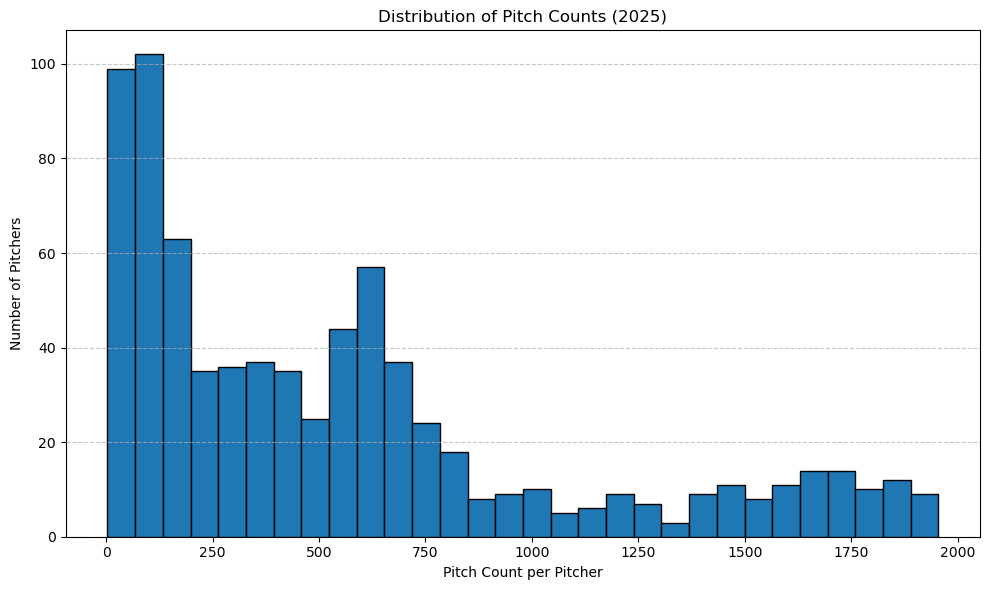

In [88]:
import matplotlib.pyplot as plt

# === Load pitcher summary if not already in memory ===
summary_path = "C:/Users/franc/Jupyter/MLB2/pitcher_2025_strike_summary.csv"
pitcher_summary = pd.read_csv(summary_path)

# === Plot histogram of pitch counts ===
plt.figure(figsize=(10, 6))
plt.hist(pitcher_summary['pitch_count'], bins=30, edgecolor='black')
plt.xlabel('Pitch Count per Pitcher')
plt.ylabel('Number of Pitchers')
plt.title('Distribution of Pitch Counts (2025)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In [43]:
# === Filter and recalculate percentiles for pitchers with >= 650 pitches ===
pitcher_summary = pitcher_summary[pitcher_summary['pitch_count'] >= 650].reset_index(drop=True)

# Recalculate percentiles within the filtered group
pitcher_summary['actual_strike_percentile'] = pitcher_summary['actual_strike_pct'].rank(pct=True) * 100
pitcher_summary['expected_strike_percentile'] = pitcher_summary['expected_strike_pct'].rank(pct=True) * 100

# Round again
pitcher_summary = pitcher_summary.round(4)

# Resave the updated CSV
pitcher_summary.to_csv("C:/Users/franc/Jupyter/MLB2/pitcher_2025_strike_summary.csv", index=False)
print("✅ Filtered and resaved pitcher summary with ≥650 pitches only.")


✅ Filtered and resaved pitcher summary with ≥650 pitches only.
